# Setup

In [15]:
import time, os, glob

import torch
torch.manual_seed(0)
import torch.nn as nn
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from tqdm import tqdm
import copy
import csv

from training.model import *
from training.datasets import *
from inference.heatmap import *

In [16]:
DEBUG = True
TILE_DIR = 'tiles2/'
MODEL_PLAQ_DIR = 'brainsec_models/CNN_model_parameters.pkl'
MODEL_SEG_DIR = 'brainsec_models/ResNet18_19.pkl'
SAVE_PLAQ_DIR = 'brainsec_outputs/heatmaps/'
TISSUE_PRESENCE_FILE = 'tissue_presence.csv'
# BrainSec
SAVE_IMG_DIR = 'brainsec_outputs/images/'
SAVE_NP_DIR = 'brainsec_outputs/numpy/'

IMG_SIZE = 1536
STRIDE = 128
# NOTE: inference loop expects batch size that is <= img size / stride and 
# where img size / batch size is an integer
BATCH_SIZE = IMG_SIZE // STRIDE
NUM_WORKERS = 2

In [17]:
USE_TISSUE_MASK = True

In [18]:
if not os.path.exists(SAVE_PLAQ_DIR):
    os.makedirs(SAVE_PLAQ_DIR)
    
if not os.path.exists(SAVE_IMG_DIR):
        os.makedirs(SAVE_IMG_DIR)
        
if not os.path.exists(SAVE_NP_DIR):
        os.makedirs(SAVE_NP_DIR)

In [19]:
# Retrieve Files
filenames = glob.glob(TILE_DIR + '*')
filenames = [filename.split('/')[-1] for filename in filenames]
filenames = sorted(filenames)
print(filenames)

['Q', 'QQ', 'QQQ', 'RR', 'RRR', 'S', 'SS', 'SSS', 'T', 'TT', 'TTT', 'U', 'UU', 'UUU']


# Inference Pipeline

In [20]:
def saveBrainSegImage(nums, save_dir) :
    """
    Converts 2D array with {0,1,2} into RGB
     to determine different segmentation areas
     and saves image at given directory
    
    Input:
       nums: 2D-NumPy Array containing classification
       save_dir: string indicating save location
    """ 
    
    nums = np.repeat(nums[:,:, np.newaxis], 3, axis=2)
    
    # nums[:,:,0] = RED, nums[:,:,1] = Green, nums[:,:,2] = Blue
    idx_1 = np.where(nums[:,:,0] == 1)  # Index of label 1 (WM)
    idx_2 = np.where(nums[:,:,0] == 2)  # Index of label 2 (GM)

    # For label 0, leave as black color
    # For label 1, set to yellow color: R255G255B0 (WM)
    nums[:,:,0].flat[np.ravel_multi_index(idx_1, nums[:,:,0].shape)] = 255
    nums[:,:,1].flat[np.ravel_multi_index(idx_1, nums[:,:,1].shape)] = 255
    nums[:,:,2].flat[np.ravel_multi_index(idx_1, nums[:,:,2].shape)] = 0
    # For label 2, set to cyan color: R0G255B255 (GM)
    nums[:,:,0].flat[np.ravel_multi_index(idx_2, nums[:,:,0].shape)] = 0
    nums[:,:,1].flat[np.ravel_multi_index(idx_2, nums[:,:,1].shape)] = 255
    nums[:,:,2].flat[np.ravel_multi_index(idx_2, nums[:,:,2].shape)] = 255

    nums = nums.astype(np.uint8) # PIL save only accepts uint8 {0,..,255}
    save_img = Image.fromarray(nums, 'RGB')
    save_img.save(save_dir)
    print("Saved at: " + save_dir)
    

In [21]:
class Net(nn.Module):

    def __init__(self, fc_nodes=512, num_classes=3, dropout=0.5):
        super(Net, self).__init__()
        
    def forward(self, x):
 
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

# Check GPU:
use_gpu = torch.cuda.is_available()

# instatiate the model
plaq_model = torch.load(MODEL_PLAQ_DIR, map_location=lambda storage, loc: storage)
seg_model = torch.load(MODEL_SEG_DIR, map_location=lambda storage, loc: storage)

if use_gpu:
    seg_model = seg_model.cuda() # Segmentation
    plaq_model = plaq_model.module.cuda() # Plaquebox-paper
else:
    seg_model = seg_model
    plaq_model = plaq_model.module

/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_78338/3424417327.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  plaq_model = torch.load(MODEL_PLAQ_DIR, map_

In [22]:
print(sum(p.numel() for p in seg_model.parameters()))
print(sum(p.numel() for p in plaq_model.parameters()))

def get_model_size_mb(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    print('model size: {:.3f}MB'.format(size_all_mb))

get_model_size_mb(seg_model)
get_model_size_mb(plaq_model)

11178051
6424403
model size: 42.678MB
model size: 24.507MB


Only process the first 2 files to test.

In [23]:
filenames = filenames[0:2]

In [24]:
import time
# Inference Loop:

for slidename in filenames:
    print("Now processing: ", slidename)
    # Read tissue presence map into list
    with open(os.path.join(TILE_DIR, slidename, TISSUE_PRESENCE_FILE), newline='') as f:
        tissue_is_present = list(csv.reader(f, quoting=csv.QUOTE_NONNUMERIC))

    row_nums = (len(tissue_is_present))
    col_nums = len(tissue_is_present[0])   
    
    # Initialize outputs accordingly:
    heatmap_res = IMG_SIZE // STRIDE
    plaque_output = np.zeros((3, heatmap_res*row_nums, heatmap_res*col_nums))
    seg_output = np.zeros((heatmap_res*row_nums, heatmap_res*col_nums), dtype=np.uint8)

    # set models to evaluation mode
    plaq_model.eval()
    seg_model.eval()

    start_time = time.perf_counter() # To evaluate Time taken per inference

    if DEBUG:
        row_range = [3, 4]
        col_range = [7, 8, 9]
    else:
        row_range = range(row_nums)
        col_range = range(col_nums)

    with torch.no_grad():
        for row in row_range:
            for col in col_range:
                print(f"Tile ({row},{col})")
                # if tile has no tissue, skip
                if USE_TISSUE_MASK and not tissue_is_present[row][col]:
                    print("No tissue. Skipping.")
                    continue
                print("Contains tissue.")
                # Load tile with padding into dataset
                image_datasets = HeatmapDataset(os.path.join(TILE_DIR, slidename, '0'), row, col, stride=STRIDE)
                dataloader = torch.utils.data.DataLoader(image_datasets, batch_size=BATCH_SIZE,
                                                        shuffle=False, num_workers=NUM_WORKERS)
                
                running_plaques = torch.Tensor(0)
                # create numpy array of heatmap
                output_class = np.zeros((heatmap_res, heatmap_res), dtype=np.uint8)
                
                for idx, data in enumerate(dataloader):
                    # get the inputs
                    inputs = data
                    # forward (Plaque Detection) :
                    p_out = plaq_model(inputs)
                    p_preds = torch.nn.functional.sigmoid(p_out) # Posibility for each class = [0,1]
                    running_plaques = torch.cat([running_plaques, p_preds])
                    
                    # forward (BrainSeg) :
                    t_out = seg_model(inputs)
                    _, t_preds = torch.max(t_out.data, 1) # indices = 0:Background, 1:WM, 2:GM

                    i = (idx // (heatmap_res//BATCH_SIZE))
                    j = (idx % (heatmap_res//BATCH_SIZE))
                    output_class[i,j*BATCH_SIZE:(j+1)*BATCH_SIZE] = t_preds.data
            
                # Final Outputs of Brain Segmentation
                seg_output[row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = output_class
                
                # Final Outputs of Plaque Detection:
                cored = np.asarray(running_plaques[:,0]).reshape(IMG_SIZE//STRIDE,IMG_SIZE//STRIDE)
                diffuse = np.asarray(running_plaques[:,1]).reshape(IMG_SIZE//STRIDE,IMG_SIZE//STRIDE)
                caa = np.asarray(running_plaques[:,2]).reshape(IMG_SIZE//STRIDE,IMG_SIZE//STRIDE)
                
                plaque_output[0, row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = cored
                plaque_output[1, row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = diffuse
                plaque_output[2, row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = caa

                seg_output[row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = output_class

    # Saving Confidence=[0,1] for Plaque Detection
    np.save(os.path.join(SAVE_PLAQ_DIR, slidename), plaque_output)
    
    # Saving BrainSeg Classification={0,1,2}
    np.save(os.path.join(SAVE_NP_DIR, slidename), seg_output)
    saveBrainSegImage(seg_output, os.path.join(SAVE_IMG_DIR, slidename + '.png'))
    
    # Time Statistics for Inference
    end_time = time.perf_counter()
    print("Time to process " + slidename + ": ", end_time-start_time, "sec")

Now processing:  Q
Tile (3,7)
No tissue. Skipping.
Tile (3,8)
No tissue. Skipping.
Tile (3,9)
Contains tissue.


/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_78338/3024884996.py:63: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  output_class[i,j*BATCH_SIZE:(j+1)*BATCH_SIZE] = t_preds.data


Tile (4,7)
No tissue. Skipping.
Tile (4,8)
Contains tissue.
Tile (4,9)
Contains tissue.
Saved at: brainsec_outputs/images/Q.png
Time to process Q:  37.37456087511964 sec
Now processing:  QQ
Tile (3,7)
No tissue. Skipping.
Tile (3,8)
No tissue. Skipping.
Tile (3,9)
No tissue. Skipping.
Tile (4,7)
No tissue. Skipping.
Tile (4,8)
No tissue. Skipping.
Tile (4,9)
No tissue. Skipping.
Saved at: brainsec_outputs/images/QQ.png
Time to process QQ:  0.054640459129586816 sec


In [25]:
def plot_heatmap(final_output) :
    """
    Plots Confidence Heatmap of Plaques = [0,1]
    
    Inputs:
        final_output (NumPy array of 
        3*img_height*height_width) :
            Contains Plaque Confidence with each axis
            representing different types of plaque
            
    Outputs:
        Subplots containing Plaque Confidences
    """
    fig = plt.figure(figsize=(12, 8))

    ax = fig.add_subplot(221)
    ax.set_title('cored')

    im = ax.imshow(final_output[0], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

    ax = fig.add_subplot(222)
    ax.set_title('diffuse')

    im = ax.imshow(final_output[1], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

    ax = fig.add_subplot(223)
    ax.set_title('CAA')
    im = ax.imshow(final_output[2], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

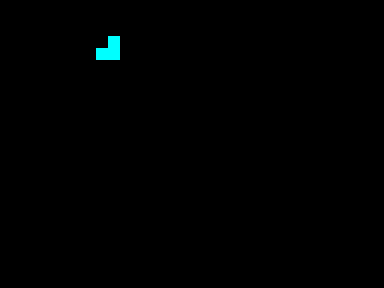

In [26]:
from IPython.display import display
tissue_seg_img = Image.open(os.path.join(SAVE_IMG_DIR, "Q.png"))
display(tissue_seg_img)

/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_78338/1405840043.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = ax.imshow(final_output[0], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_78338/1405840043.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = ax.imshow(final_output[1], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_78338/1405840043.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.co

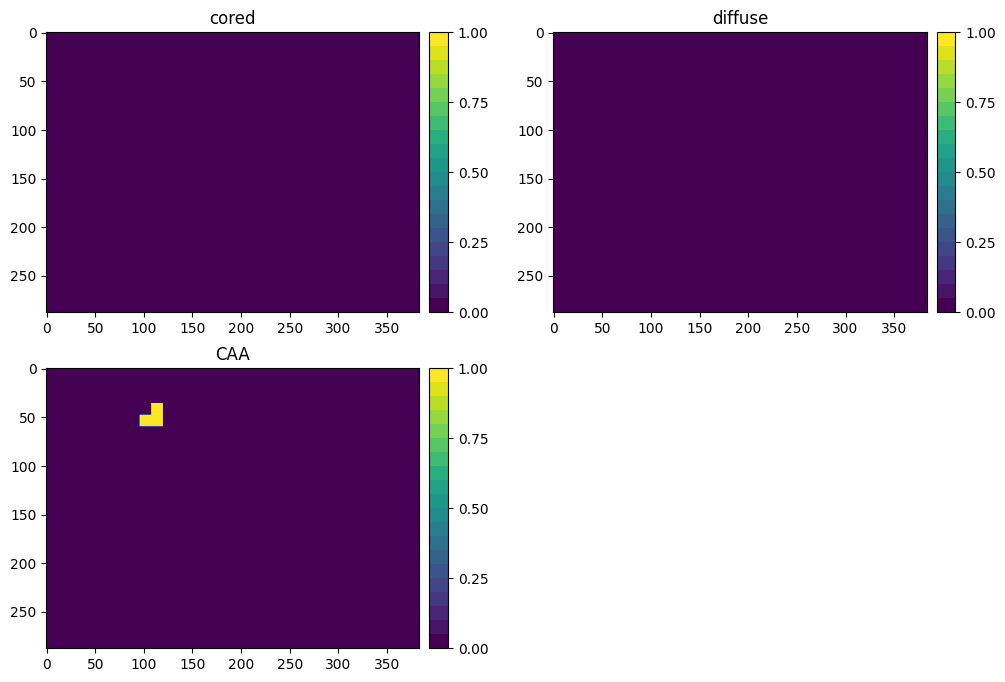

In [27]:
plaque_output = np.load(SAVE_PLAQ_DIR + 'Q.npy')
plot_heatmap(plaque_output)

# Post Processing